In [ ]:
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link="https://drive.google.com/file/d/1IwbMhP1yx9hdZsmA2u6kvJJCHLJ0sC4U/view?usp=sharing"
id="1IwbMhP1yx9hdZsmA2u6kvJJCHLJ0sC4U"
d = drive.CreateFile({'id':id}) 
d.GetContentFile('timeseries.csv')
df=pd.read_csv("timeseries.csv")

In [ ]:
df.head()

,Unnamed: 0,sn,Group,air_temp,max_temp,min_temp,RH,Max_rh,Min_rh,Wind_Speed_1,Wind_Dir_1,Wind_Speed_2,Wind_Dir_2,Solar_Rad,Diffuse_Rad,Dew_Pt,Batt_Voltage,date_time,Time,date,date_time_formatted
0,0,1,1,27.822222,27.841111,27.715556,49.024444,49.562222,48.895556,4.833333,104.111111,3.555556,97.0,603.555556,563.333333,16.133333,14.1,01/02/ 2013 - 10:47,10:47,2013-02-01,2013-02-01 10:47
1,1,2,2,28.332000,28.350000,28.273000,47.903000,48.610000,47.614000,3.940000,107.200000,2.780000,120.3,615.300000,576.300000,16.234000,14.1,01/02/ 2013 - 10:59,10:59,2013-02-01,2013-02-01 10:59
2,2,3,3,28.450000,28.491000,28.429000,46.894000,47.140000,46.621000,5.640000,101.800000,4.150000,107.1,627.200000,589.200000,16.011000,14.1,01/02/ 2013 - 11:09,11:09,2013-02-01,2013-02-01 11:09
3,3,4,4,28.613000,28.622000,28.551000,46.444000,46.913000,46.157000,4.800000,109.000000,3.350000,121.5,635.300000,597.800000,16.006000,14.1,01/02/ 2013 - 11:19,11:19,2013-02-01,2013-02-01 11:19
4,4,5,5,28.850000,28.887000,28.820000,45.334000,45.709000,44.934000,5.920000,95.700000,4.270000,92.0,641.900000,606.200000,15.843000,14.1,01/02/ 2013 - 11:29,11:29,2013-02-01,2013-02-01 11:29


In [ ]:
df=df.drop(df.iloc[:,0:9],axis=1)
df.head()

,Wind_Speed_1,Wind_Dir_1,Wind_Speed_2,Wind_Dir_2,Solar_Rad,Diffuse_Rad,Dew_Pt,Batt_Voltage,date_time,Time,date,date_time_formatted
0,4.833333,104.111111,3.555556,97.0,603.555556,563.333333,16.133333,14.1,01/02/ 2013 - 10:47,10:47,2013-02-01,2013-02-01 10:47
1,3.940000,107.200000,2.780000,120.3,615.300000,576.300000,16.234000,14.1,01/02/ 2013 - 10:59,10:59,2013-02-01,2013-02-01 10:59
2,5.640000,101.800000,4.150000,107.1,627.200000,589.200000,16.011000,14.1,01/02/ 2013 - 11:09,11:09,2013-02-01,2013-02-01 11:09
3,4.800000,109.000000,3.350000,121.5,635.300000,597.800000,16.006000,14.1,01/02/ 2013 - 11:19,11:19,2013-02-01,2013-02-01 11:19
4,5.920000,95.700000,4.270000,92.0,641.900000,606.200000,15.843000,14.1,01/02/ 2013 - 11:29,11:29,2013-02-01,2013-02-01 11:29


In [ ]:
df=df.drop(df.iloc[:,1:],axis=1)
df.head()

,Wind_Speed_1
0,4.833333
1,3.940000
2,5.640000
3,4.800000
4,5.920000


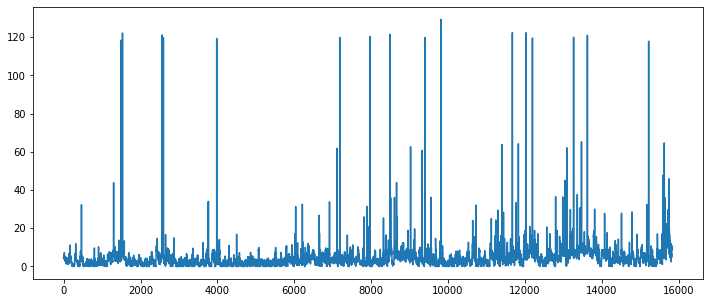

In [ ]:
df['Wind_Speed_1'].plot(figsize=(12,5))

**CHECKING FOR STATIONARITY**

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df['Wind_Speed_1'])

1. ADF :  -11.223018225504484
2. P-Value :  1.9918157555100237e-20
3. Num Of Lags :  41
4. Num Of Observations Used For ADF Regression: 15794
5. Critical Values :
	 1% :  -3.430764104288153
	 5% :  -2.8617230168568444
	 10% :  -2.5668674153382516


In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import arima
d=arima.ndiffs(df)
d


1

In [ ]:
#Since p>0.05 data is not stationary.
#To make it stationary differncing is done.
#The pmdarima library is used to find the order of differencing to make the data stationary.

from pmdarima import auto_arima
stepwise_fit=auto_arima(df["Wind_Speed_1"],trace=True,suppress_warning=True)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=93191.991, Time=8.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=100965.234, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=97266.852, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=93307.774, Time=4.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=100963.234, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=42.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=93175.647, Time=8.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=93188.016, Time=7.48 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=95750.096, Time=1.71 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=93164.024, Time=14.25 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=94926.895, Time=2.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=93145.182, Time=21.28 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=94417.859, Time=3.34 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=93096.750, Time=37.71 sec
 ARIMA(5,1,0)(0,0,0

In [ ]:
#Best ARIMA model seems to be of order (5,1,1) with minimum AIC score of 93094.822
train=df.iloc[:-1000]
test=df.iloc[-1000:]
train.shape,test.shape

((14836, 1), (1000, 1))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(df,order=(5,1,1))
model_fit=model.fit()
model_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Wind_Speed_1   No. Observations:                15835
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -46540.375
Method:                       css-mle   S.D. of innovations              4.573
Date:                Thu, 28 Jan 2021   AIC                          93096.750
Time:                        09:47:31   BIC                          93158.110
Sample:                             1   HQIC                         93117.054
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0003      0.001      0.269      0.788      -0.002       0.002
ar.L1.D.Wind_Speed_1     0.1864      0.008     21.941      0.000       0.170       0.203
ar.L2.D.Wind_Speed_1     0.0905      0.008     10.693      0.000       0.074       0.107
ar.L3.D.Wind_Speed_1     0.0745      0.008      8.821      0.000       0.058       0.091
ar.L4.D.Wind_Speed_1     0.0675      0.008      8.012      0.000       0.051       0.084
ar.L5.D.Wind_Speed_1     0.0684      0.008      8.157      0.000       0.052       0.085
ma.L1.D.Wind_Speed_1    -0.9850      0.003   -341.043      0.000      -0.991      -0.979
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2977           -0.0000j            1.2977           -0.0000
AR.2            0.4274           -1.7052j            1.7579           -0.2109
AR.3            0.4274           +1.7052j            1.7579            0.2109
AR.4           -1.5697           -1.0876j            1.9097           -0.4036
AR.5           -1.5697           +1.0876j            1.9097            0.4036
MA.1            1.0153           +0.0000j            1.0153            0.0000
-----------------------------------------------------------------------------
"""

**PLOTTING ACTUAL VS PREDICTIONS**

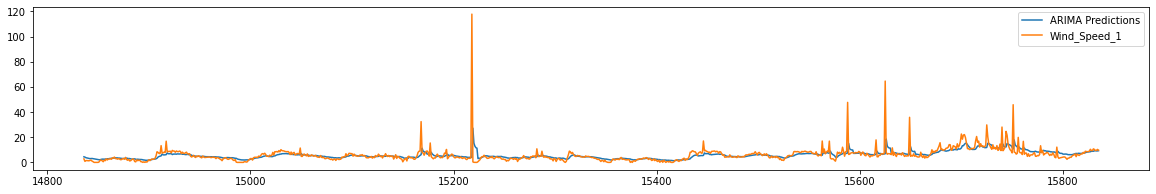

In [ ]:
plt.rcParams['figure.figsize']=(20,3)
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Wind_Speed_1'].plot(legend=True)

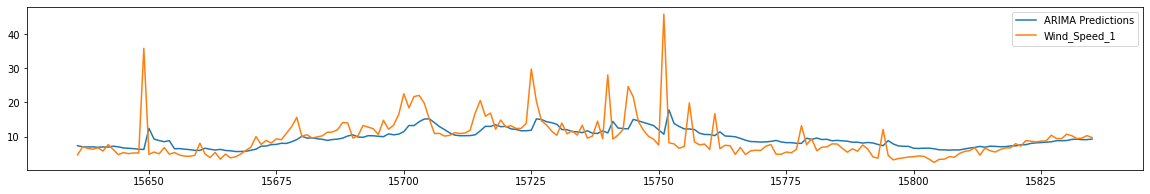

In [ ]:
##plottig last 200 values alone for better visualization
pred[800:].plot(legend=True)
test['Wind_Speed_1'][800:].plot(legend=True)

**CHECKING ACCURACY METRIC**

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test['Wind_Speed_1'].mean()
rmse=sqrt(mean_squared_error(pred,test['Wind_Speed_1']))
print("rmse: ",rmse)

rmse:  5.265664919671761
